In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, Input
import matplotlib.pyplot as plt

In [6]:
address = r"IMU Dataset\Data"

learnRate = 1e-4
batchSize = 5
patience = 4
epoch = 200

window_stride = 10
sample_len = 200
sample_per_trial = 5
features = 45
static_features = 4
volunteers = 30
train_portion = 0.8
val_portion = 0.9
classes = 5

trunk = 1
thighR = 2
thighL = 3
shankR = 4
shankL = 5
wrist = 6

headers = ['Acc_X', 'Acc_Y', 'Acc_Z', 
        'Gyr_X', 'Gyr_Y', 'Gyr_Z', 
        'Roll', 'Pitch', 'Yaw']

norm = {'Acc_X': [-20.59292, 31.47302], 
        'Acc_Y': [-13.67152, 19.44969], 
        'Acc_Z': [-35.48537, 18.8095], 
        'Gyr_X': [-6.838557, 7.868352], 
        'Gyr_Y': [-16.90477, 16.61124], 
        'Gyr_Z': [-4.431263, 6.664771], 
        'Roll': [-207.2701, 214.6915], 
        'Pitch': [-89.953, 87.27671], 
        'Yaw': [-203.8373, 204.2526]}

In [3]:
def normalize_fixed(x, current_range, normed_range):
    current_min, current_max = current_range
    normed_min, normed_max = normed_range
    x_normed = (x - current_min) / (current_max - current_min)
    x_normed = x_normed * (normed_max - normed_min) + normed_min
    return x_normed

def trialLabel(num):
    if num in range(4, 10):
        return 0  # 'FE'
    if num in [16, 18, 20, 22, 24, 26]:
        return 1  # 'StrU'
    if num in [17, 19, 21, 23, 25, 27]:
        return 2  # 'StrD'
    if num in [28, 30, 32, 34, 36, 38]:
        return 3  # 'SlpU'
    if num in [29, 31, 33, 35, 37, 39]:
        return 4  # 'SlpD'
    print('Check dataset!')


def trialName(num):
    if num in range(4, 10):
        return 'FE: 0'
    if num in [16, 18, 20, 22, 24, 26]:
        return 'StrU: 1'
    if num in [17, 19, 21, 23, 25, 27]:
        return 'StrD: 2'
    if num in [28, 30, 32, 34, 36, 38]:
        return 'SlpU: 3'
    if num in [29, 31, 33, 35, 37, 39]:
        return 'SlpD: 4'
    return False


def trialInd(num):
    if num == 0:
        return 'FE: 0'
    if num == 1:
        return 'StrU: 1'
    if num == 2:
        return 'StrD: 2'
    if num == 3:
        return 'SlpU: 3'
    if num == 4:
        return 'SlpD: 4'
    return False


def openCSV(addr):
    df = pd.read_csv(addr, sep=',', header=None)
    header = df.iloc[0]
    df = pd.DataFrame(df[1:], dtype=float)
    df.columns = header
    return df

In [4]:
try:
    with open('Objects\\data', 'rb') as f:
        data = pickle.load(f)
    print("Loaded saved objects")
        
except:
    data = []
    for person in range(0, volunteers):
        tmp1 = []
        print(person + 1, "out of", volunteers)
        for trial in range(0, 57):
            tmp2 = []
            for sensor in range(0, 6):
                tmp2.append(openCSV(address + f"\\person{person + 1}_trial{trial + 1}_sensor{sensor + 1}.csv"))
            tmp1.append(tmp2)
        data.append(tmp1)

    with open("Objects\\data", 'ab') as f:
        pickle.dump(data, f)

Loaded saved objects


In [5]:
# dic = {'Acc_X': [1e10, -1e10], 'Acc_Y': [1e10, -1e10], 'Acc_Z': [1e10, -1e10],
#         'Gyr_X': [1e10, -1e10], 'Gyr_Y': [1e10, -1e10], 'Gyr_Z': [1e10, -1e10], 
#         'Roll': [1e10, -1e10], 'Pitch': [1e10, -1e10], 'Yaw': [1e10, -1e10]}

# for person in range(0, volunteers):
#     for trial in list(range(3, 9)) + list(range(15, 39)):
#         flag = False
#         for i in range(samplePerTrial):
#             for sample in range(i * sampleLen, sampleLen + i * sampleLen):
#                 for sensor in range(1, 5):
#                     if flag:
#                         break
#                     if len(data[person][trial][sensor]) < optLen:
#                         flag = True
#                         continue
#                     for para in ['Acc_X', 'Acc_Y', 'Acc_Z', 
#                                 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 
#                                 'Roll', 'Pitch', 'Yaw']:
#                         if data[person][trial][sensor][para].values[sample] > dic[para][1]:
#                             dic[para][1] = data[person][trial][sensor][para].values[sample]
#                         elif data[person][trial][sensor][para].values[sample] < dic[para][0]:
#                             dic[para][0] = data[person][trial][sensor][para].values[sample]

# print(dic)

In [5]:
dic2 = {'AGE': [1e10, -1e10], 'HEIGHT': [1e10, -1e10], 'WEIGHT': [1e10, -1e10]}
subjects = []

with open('subjects.txt') as f:
    for r in f:
        r = r.split()
        subjects.append([float(r[1]), float(r[3]), float(r[4]), 1.0 if r[2] == 'F' else 0.0])

        if float(r[1]) < dic2['AGE'][0]:
            dic2['AGE'][0] = float(r[1])
        if float(r[1]) > dic2['AGE'][1]:
            dic2['AGE'][1] = float(r[1])

        if float(r[3]) < dic2['HEIGHT'][0]:
            dic2['HEIGHT'][0] = float(r[3])
        if float(r[3]) > dic2['HEIGHT'][1]:
            dic2['HEIGHT'][1] = float(r[3])

        if float(r[4]) < dic2['WEIGHT'][0]:
            dic2['WEIGHT'][0] = float(r[4])
        if float(r[4]) > dic2['WEIGHT'][1]:
            dic2['WEIGHT'][1] = float(r[4])

for i in range(len(subjects)):
    subjects[i][0] = normalize_fixed(subjects[i][0], [dic2['AGE'][0], dic2['AGE'][1]], [-1, 1])
    subjects[i][1] = normalize_fixed(subjects[i][1], [dic2['HEIGHT'][0], dic2['HEIGHT'][1]], [-1, 1])
    subjects[i][2] = normalize_fixed(subjects[i][2], [dic2['WEIGHT'][0], dic2['WEIGHT'][1]], [-1, 1])

In [5]:
try:
    with open('Objects\\inputs', 'rb') as f:
        inputs = pickle.load(f)
    with open('Objects\\targets', 'rb') as f:
        targets = pickle.load(f)
    with open('Objects\\statics', 'rb') as f:
        statics = pickle.load(f)
    print("Loaded saved objects")
        
except:
    inputs = np.empty((200000, sample_len, features), dtype=float)
    targets = []
    statics = []
    counter = 0
    errors = 0

    for person in range(0, volunteers):
        print(person + 1, "out of", volunteers)
        for trial in list(range(3, 9)) + list(range(15, 39)):
            opt_len = min([len(data[person][trial][s]) for s in range(5)])
            for i in range(0, opt_len - sample_len, window_stride):
                for sample in range(i, i + sample_len):
                    for sensor in range(0, 5):
                        for ind, para in enumerate(headers):
                            raw_data = data[person][trial][sensor][para].values[sample]
                            if not np.isfinite(raw_data):
                                raw_data = 0
                                errors += 1
                            norm_data = normalize_fixed(raw_data, norm[para], [-1, 1])
                            inputs[counter][sample - i][ind + len(headers) * sensor] = norm_data
                targets.append(int(trialLabel(trial + 1)))
                statics.append([subjects[person]])
                counter += 1

    print(errors)   

    inputs = inputs[:counter]
    with open("Objects\\inputs", 'ab') as f:
        pickle.dump(inputs, f)
    with open("Objects\\targets", 'ab') as f:
        pickle.dump(targets, f)
    with open("Objects\\statics", 'ab') as f:
        pickle.dump(statics, f)

print(len(inputs))

Loaded saved objects
132409


In [6]:
inputs2, statics2, targets2 = shuffle(inputs, statics, targets)

del inputs
del targets
del statics

statics2 = tf.convert_to_tensor(statics2)
targets2 = tf.one_hot(targets2, classes)

train = inputs2[:int(train_portion * len(inputs2))]
train_s = statics2[:int(train_portion * len(inputs2))]
train_label = targets2[:int(train_portion * len(inputs2))]

val = inputs2[int(train_portion * len(inputs2)):int(val_portion * len(inputs2))]
val_s = statics2[int(train_portion * len(inputs2)):int(val_portion * len(inputs2))]
val_label = targets2[int(train_portion * len(inputs2)):int(val_portion * len(inputs2))]

test = inputs2[int(val_portion * len(inputs2)):]
test_s = statics2[int(val_portion * len(inputs2)):]
test_label = targets2[int(val_portion * len(inputs2)):]

del inputs2
del targets2
del statics2

print(test.shape, test_s.shape, test_label.shape)

(13241, 200, 45) (13241, 1, 4) (13241, 5)


In [ ]:
### CNN

model_cnn = models.Sequential()

model_cnn.add(layers.Conv1D(18, 2, strides=2, activation=tf.nn.relu, input_shape=(sample_len, features)))
model_cnn.add(layers.MaxPooling1D(pool_size=2, strides=2))

model_cnn.add(layers.Conv1D(36, 2, strides=2, activation=tf.nn.relu))
model_cnn.add(layers.MaxPooling1D(pool_size=2, strides=1))

model_cnn.add(layers.Conv1D(72, 2, strides=2, activation=tf.nn.relu))
model_cnn.add(layers.MaxPooling1D(pool_size=2, strides=1))

model_cnn.add(layers.Conv1D(144, 2, strides=2, activation=tf.nn.relu))
model_cnn.add(layers.MaxPooling1D(pool_size=2, strides=2))

model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.Dropout(0.5))

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(classes, activation='softmax'))


model_cnn.compile(optimizer=optimizers.Adam(learning_rate=learnRate), metrics=['accuracy'],
            loss=losses.CategoricalCrossentropy(from_logits=False))

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history_cnn = model_cnn.fit(train, train_label, batch_size=batchSize, epochs=epoch, 
                            validation_data=(val, val_label), callbacks=[earlyStop], shuffle=False)


### LSTM
model_rnn = models.Sequential()

model_rnn.add(layers.LSTM(32, return_sequences=True, input_shape=(sample_len, features)))

model_rnn.add(layers.Flatten())

model_rnn.add(layers.Dense(classes, activation='softmax'))


model_rnn.compile(optimizer=optimizers.Adam(learning_rate=learnRate), 
                metrics=['accuracy'],
                loss=losses.CategoricalCrossentropy(from_logits=False))

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history_rnn = model_rnn.fit(train, train_label, batch_size=batchSize, epochs=epoch, 
                            validation_data=(val, val_label), callbacks=[earlyStop], shuffle=False)


plt.plot(history_cnn.history['accuracy'], 'b:', label="CNN Training Accuracy")
plt.plot(history_cnn.history['val_accuracy'], 'r:', label="CNN Validation Accuracy")
plt.plot(history_rnn.history['accuracy'], 'b-.', label="LSTM Training Accuracy")
plt.plot(history_rnn.history['val_accuracy'], 'r-.', label="LSTM Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

print(f"Test Accuracy CNN: {model_cnn.evaluate(test, test_label)[1] * 100:.2f}%")
print(f"Test Accuracy LSTM: {model_rnn.evaluate(test, test_label)[1] * 100:.2f}%")

In [ ]:
### LSTM + SLP
time_series_input = Input(shape=(sample_len, features))
static_input = Input(shape=(1, static_features))

lstm = layers.LSTM(32, return_sequences=True)(time_series_input)
static = layers.Dense(32, activation='relu')(static_input)

main = layers.Concatenate(axis= 1)([lstm, static])
flat = layers.Flatten()(main)
out = layers.Dense(classes, activation='softmax')(flat)


model_rnn = models.Model(inputs=[time_series_input, static_input],
                            outputs=out)

model_rnn.compile(optimizer=optimizers.Adam(learning_rate=learnRate), 
                metrics=['accuracy'],
                loss=losses.CategoricalCrossentropy(from_logits=False))

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history_rnn = model_rnn.fit([train, train_s], train_label, batch_size=batchSize, epochs=epoch, 
                            validation_data=([val, val_s], val_label), callbacks=[earlyStop], shuffle=False)


plt.plot(history_rnn.history['accuracy'], 'b-.', label="LSTM Training Accuracy")
plt.plot(history_rnn.history['val_accuracy'], 'r-.', label="LSTM Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

print(f"Test Accuracy LSTM: {model_rnn.evaluate([test, test_s], test_label)[1] * 100:.2f}%")

Epoch 1/200
21186/21186 [==============================] - 337s 15ms/step - loss: 0.2006 - accuracy: 0.9290 - val_loss: 0.0773 - val_accuracy: 0.9773
Epoch 2/200
21186/21186 [==============================] - 325s 15ms/step - loss: 0.0583 - accuracy: 0.9810 - val_loss: 0.0458 - val_accuracy: 0.9866
Epoch 3/200
21186/21186 [==============================] - 326s 15ms/step - loss: 0.0398 - accuracy: 0.9871 - val_loss: 0.0320 - val_accuracy: 0.9900
Epoch 4/200
21186/21186 [==============================] - 320s 15ms/step - loss: 0.0314 - accuracy: 0.9899 - val_loss: 0.0298 - val_accuracy: 0.9906
Epoch 5/200
21186/21186 [==============================] - 320s 15ms/step - loss: 0.0275 - accuracy: 0.9908 - val_loss: 0.0289 - val_accuracy: 0.9906
Epoch 6/200
21186/21186 [==============================] - 321s 15ms/step - loss: 0.0241 - accuracy: 0.9917 - val_loss: 0.0291 - val_accuracy: 0.9897
Epoch 7/200
21186/21186 [==============================] - 323s 15ms/step - loss: 0.0216 - accuracy:

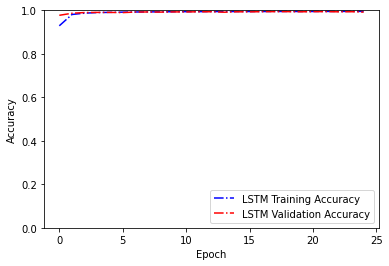

In [7]:
### LSTM + CNN
# try:
#     model_rnn = models.load_model('model')

# except Exception as e:
time_series_input = Input(shape=(sample_len, features))
static_input = Input(shape=(1, static_features))

lstm = layers.LSTM(32, return_sequences=True)(time_series_input)
static1 = layers.Conv1D(32, 1, strides=1, activation=tf.nn.relu)(static_input)
static2 = layers.MaxPooling1D(pool_size=1, strides=1)(static1)

main = layers.Concatenate(axis= 1)([lstm, static2])
flat = layers.Flatten()(main)
out = layers.Dense(classes, activation='softmax')(flat)


model_rnn = models.Model(inputs=[time_series_input, static_input],
                            outputs=out)

model_rnn.compile(optimizer=optimizers.Adam(learning_rate=learnRate), 
                metrics=['accuracy'],
                loss=losses.CategoricalCrossentropy(from_logits=False))

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history_rnn = model_rnn.fit([train, train_s], train_label, batch_size=batchSize, epochs=epoch, 
                            validation_data=([val, val_s], val_label), callbacks=[earlyStop], shuffle=False)


plt.plot(history_rnn.history['accuracy'], 'b-.', label="LSTM Training Accuracy")
plt.plot(history_rnn.history['val_accuracy'], 'r-.', label="LSTM Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [8]:
model_rnn.save('model2')

with open("test2", 'ab') as f:
    pickle.dump(test, f)
with open("test_s2", 'ab') as f:
    pickle.dump(test_s, f)
with open("test_label2", 'ab') as f:
    pickle.dump(test_label, f)

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


In [3]:
with open('test', 'rb') as f:
    test = pickle.load(f)
with open('test_s', 'rb') as f:
    test_s = pickle.load(f)
with open('test_label', 'rb') as f:
    test_label = pickle.load(f)

print(f"Test Accuracy LSTM: {model_rnn.evaluate([test, test_s], test_label)[1] * 100:.2f}%")

414/414 [==============================] - 8s 9ms/step - loss: 0.0234 - accuracy: 0.9918
Test Accuracy LSTM: 99.18%
